In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE



# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
pd.set_option('mode.chained_assignment', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "/content/drive/MyDrive/AXA_Submission/"
df=pd.read_csv(path+'depression_data.csv')


In [5]:
df.drop(columns=["Name"], inplace = True)

In [6]:
def new_y(y):
  le = LabelEncoder()
  return le.fit_transform(y)

In [7]:
def new_X(X):
  transformer_social = ColumnTransformer(transformers=[
    ('s1', OneHotEncoder(), ['Marital Status', 'Employment Status']),
    ('s2', OrdinalEncoder(categories=[['High School','Associate Degree',"Bachelor's Degree", "Master's Degree",'PhD']]),['Education Level'])
    ],remainder='drop')
  pipe_social = Pipeline([
    ('num_s', transformer_social),
    ('scaler_s', MinMaxScaler()),
    ('pca_s', PCA(n_components=1))])
  transformer_health = ColumnTransformer(transformers=[
    ('h1', OneHotEncoder(), ['Smoking Status', 'Sleep Patterns']),
    ('h2', OrdinalEncoder(categories=[['Active', 'Moderate', 'Sedentary'],
                                     ['Low','Moderate', 'High'],
                                     ['Healthy', 'Moderate', 'Unhealthy']]),['Physical Activity Level', 'Alcohol Consumption', 'Dietary Habits'])
    ],remainder='drop')
  pipe_health = Pipeline([
    ('num_h', transformer_health),
    ('scaler_h', MinMaxScaler()),
    ('pca_h', PCA(n_components=1))])

  transformer_history = ColumnTransformer(transformers=[
    ('hh1', OneHotEncoder(), ['History of Substance Abuse','Family History of Depression', 'Chronic Medical Conditions'])]
    ,remainder='drop')

  pipe_history = Pipeline([
    ('num_h', transformer_history),
    ('pca_h', PCA(n_components=1))])

  transformer_num = ColumnTransformer(transformers=[
    ('t1', MinMaxScaler(), ["Age", "Number of Children", "Income"])]
    ,remainder='drop')

  num_col = transformer_num.fit_transform(X)
  Health_History = pipe_history.fit_transform(X)
  Health_Status = pipe_health.fit_transform(X)
  Social_Status = pipe_social.fit_transform(X)

  return np.hstack((num_col, Social_Status,Health_Status, Health_History))

In [8]:
X = df.drop(["History of Mental Illness"], axis=1)
y = df["History of Mental Illness"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)


In [10]:
X_train = new_X(X_train)
X_test = new_X(X_test)
y_train = new_y(y_train)
y_test  = new_y(y_test)

In [11]:
sm = SMOTE(random_state=46)
X_sam, y_sam = sm.fit_resample(X_train, y_train)

X_train_oversampled = X_sam
y_train_oversampled = y_sam

In [12]:
def model_matric(model, label):
  model.fit(X_train_oversampled,y_train_oversampled)
  y_pred = model.predict(X_test)
  print(model.score(X_train_oversampled,y_train_oversampled))
  print(model.score(X_test,y_test))
  roc_auc = roc_auc_score(y_test, y_pred)
  fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

  # Plot the ROC curve
  fig, ax = plt.subplots()
  ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  # roc curve for tpr = fpr
  ax.plot([0, 1], [0, 1], 'k--', label=label)
  ax.set(xlabel='False Positive Rate',ylabel='True Positive Rate')
  ax.set_title('ROC Curve')
  ax.legend(loc="lower right")
  return ax

0.6194996116479577
0.5345119269159194


<Axes: title={'center': 'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

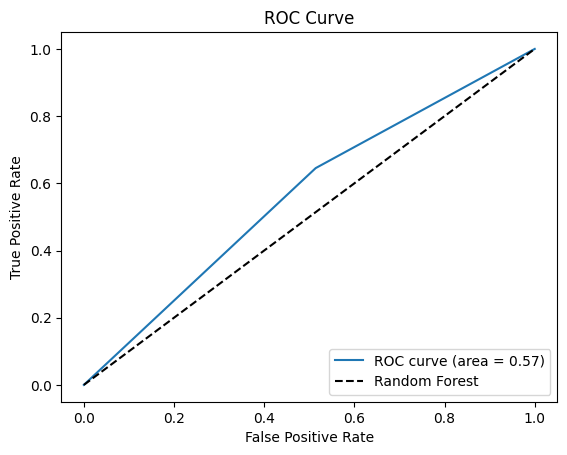

In [13]:
rf_grid_search = RandomForestClassifier(max_depth= 6, min_samples_leaf= 4, min_samples_split= 3,random_state=46)
#print(rf_grid_search.score(X_train,y_train))

model_matric (rf_grid_search, "Random Forest")


0.5730448969673828
0.6143267999129951


<Axes: title={'center': 'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

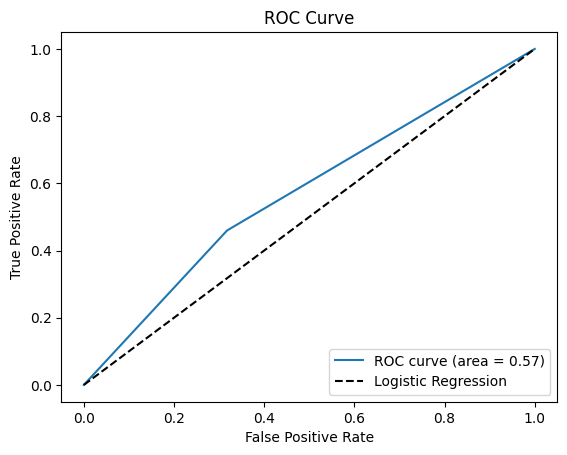

In [14]:
lr_grid_search = LogisticRegression(C= 0.1, penalty= 'l1', solver= 'liblinear',random_state=46)
#print(lr_grid_search.score(X_train,y_train))

model_matric (lr_grid_search, "Logistic Regression")

1.0
0.5781351958817701


<Axes: title={'center': 'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

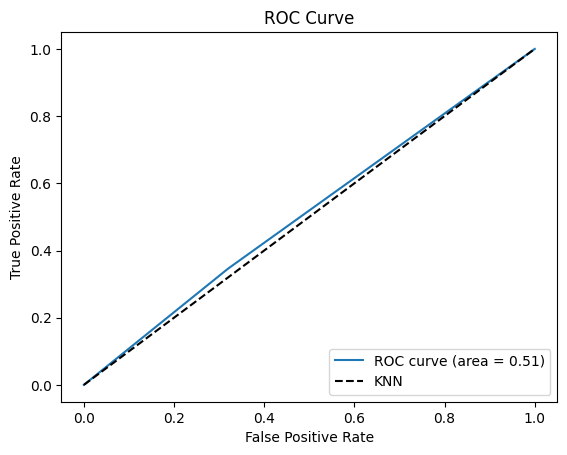

In [15]:
knn_grid_search = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 2, weights= 'distance')


model_matric (knn_grid_search, "KNN")

0.5813131072068592
0.6123087705730237


<Axes: title={'center': 'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

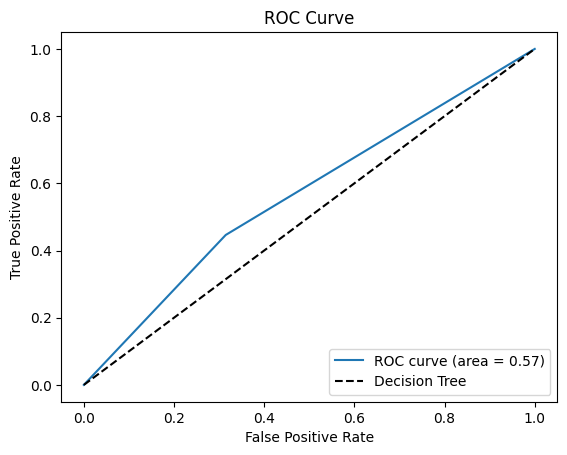

In [16]:
dt_grid_search = DecisionTreeClassifier(criterion= 'gini', max_depth= 4, min_samples_leaf= 2, min_samples_split= 3,random_state=42)
model_matric (dt_grid_search, "Decision Tree")


0.7264135797380034
0.44295139811972833


<Axes: title={'center': 'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

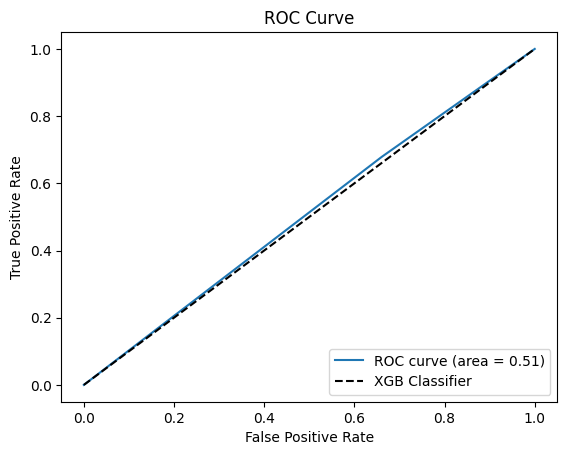

In [17]:
xgb_grid_search = XGBClassifier(learning_rate = 0.2, max_depth= 6, min_child_weight= 2, n_estimators= 200, objective='binary:logistic', subsample= 1.0,random_state=46)
model_matric(xgb_grid_search, "XGB Classifier")

